# Generating Cell Embeddings

Please install the following packages before running this notebook:
```bash
pip install pandas transformers
```

<!-- In order to generate cell embeddings, we will use the `cell2location` package. This package is designed to map the location of single cells in situ, using a reference atlas. It uses a Bayesian model to estimate the expression of each gene in each cell type, and the proportion of each cell type in each location. The model is implemented in PyMC3, and the package provides a high-level interface to the model, as well as tools for visualisation and interpretation of the results. -->

In [1]:
# !pip install pandas transformers

## Load Toy Dataset

In [2]:
import os
import pandas as pd

data_dir = 'data/'
protac_df = pd.read_csv(os.path.join(data_dir, 'PROTAC-Degradation-DB.csv'))
print(len(protac_df))
print(len(protac_df['POI Sequence'].dropna()))

2141
2141


In [3]:
protac_cells = protac_df['Cell Line Identifier'].dropna().unique().tolist()
print(f'Number of cell lines: {len(protac_cells)}')

Number of cell lines: 138


## Load Cellosaurus

The Cellosaurus is a knowledge resource on cell lines. It attempts to describe all cell lines used in biomedical research. It is the result of curation efforts by the Swiss Institute of Bioinformatics and ExPASy.

The notebook expects a file named `cellosaurus.txt` in the `data` directory of the repository. This file can be downloaded from the [Cellosaurus FTP](https://ftp.expasy.org/databases/cellosaurus/cellosaurus.txt).

In [4]:
def parse_cellosaurus_text(file_path):
    """
    Parse a Cellosaurus text file and return a list of cell line entries.

    :param file_path: Path to the Cellosaurus text file.
    :return: A list of dictionaries, each representing a cell line entry.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    cell_lines = []
    cell_line_entry = {}
    for line in lines:
        if line.startswith("ID   "):
            if cell_line_entry:
                cell_lines.append(cell_line_entry)
                cell_line_entry = {}
            cell_line_entry['ID'] = line[5:].strip()
        elif line.startswith("AC   "):
            cell_line_entry['AC'] = line[5:].strip()
        elif line.startswith("SY   "):
            cell_line_entry['SY'] = line[5:].strip()
        elif line.startswith("DR   "):
            cell_line_entry.setdefault('DR', []).append(line[5:].strip())
        elif line.startswith("RX   "):
            cell_line_entry.setdefault('RX', []).append(line[5:].strip())
        elif line.startswith("CC   "):
            cell_line_entry.setdefault('CC', []).append(line[5:].strip())
        elif line.startswith("OX   "):
            cell_line_entry['OX'] = line[5:].strip()
        elif line.startswith("HI   "):
            cell_line_entry['HI'] = line[5:].strip()
        elif line.startswith("CA   "):
            cell_line_entry['CA'] = line[5:].strip()
        elif line.startswith("DT   "):
            cell_line_entry['DT'] = line[5:].strip()
        # Add similar elif blocks for other line codes as needed

    # Add the last entry
    if cell_line_entry:
        cell_lines.append(cell_line_entry)

    return cell_lines


# Example usage
file_path = os.path.join(data_dir, "cellosaurus.txt")
cell_lines = parse_cellosaurus_text(file_path)
for cell_line in cell_lines:
    print(cell_line)
    break

{'ID': '#132 PC3-1-SC-E8', 'AC': 'CVCL_B0T9', 'SY': 'Z48-5MG-70', 'DR': ['Wikidata; Q108819335'], 'RX': ['Patent=EP0501779A1;'], 'CC': ['Group: Patented cell line.', 'Registration: International Depositary Authority, American Type Culture Collection (ATCC); HB-10564.', 'Monoclonal antibody isotype: IgG2a.', 'Monoclonal antibody target: UniProtKB; P47712; Human PLA2G4A.'], 'OX': 'NCBI_TaxID=10090; ! Mus musculus (Mouse)', 'HI': 'CVCL_D145 ! HL-1 Friendly Myeloma-653', 'CA': 'Hybridoma', 'DT': 'Created: 23-09-21; Last updated: 30-01-24; Version: 4'}


In [5]:
cell2data = {}
for cell_line in cell_lines:
    cell2data[cell_line['ID']] = cell_line

In [6]:
cc_headers = set()

for i, cell_line in enumerate(cell_lines):
    if 'CC' in cell_line:
        # Add the CC headers to the set
        cc_headers.update([cc_line.split(':')[0].strip()
                          for cc_line in cell_line['CC']])

for cc_header in cc_headers:
    print(cc_header)

cc_headers_to_ignore = [
    'Miscellaneous',
    'From',
    'Anecdotal',
    'Misspelling',
    'Part of',
    'Registration',
    'Discontinued',
]

Knockout cell
Miscellaneous
Discontinued
Omics
Misspelling
Population
Transfected with
Donor information
From
Breed/subspecies
Problematic cell line
Derived from site
Biotechnology
Registration
Anecdotal
Virology
Monoclonal antibody isotype
Monoclonal antibody target
Sequence variation
Characteristics
Microsatellite instability
Group
Selected for resistance to
HLA typing
Senescence
Part of
Doubling time
Karyotypic information
Caution
Genome ancestry
Cell type
Transformant


In [7]:
protac_cells_df = []
for cell in cell2data.keys():
    cell_data = cell2data[cell].copy()
    for comment in cell_data.get('CC', []):
        cc_header = comment.split(':')[0].strip()
        if cc_header not in cc_headers_to_ignore:
            cc_text = comment.split(':')[1].strip()
            cell_data[cc_header] = cell_data.get(cc_header, '') + cc_text + ' '
    cell_data.pop('CC', None)
    cell_data.pop('DT', None)
    cell_data.pop('SY', None)
    protac_cells_df.append(cell_data)

protac_cells_df = pd.DataFrame(protac_cells_df)
# Drop all-Nan columns
protac_cells_df = protac_cells_df.dropna(axis=1, how='all')
protac_cells_df

,ID,AC,DR,RX,OX,HI,CA,Group,Monoclonal antibody isotype,Monoclonal antibody target,...,Problematic cell line,Knockout cell,Karyotypic information,Virology,Senescence,Biotechnology,Donor information,Caution,Genome ancestry,Microsatellite instability
0,#132 PC3-1-SC-E8,CVCL_B0T9,[Wikidata; Q108819335],[Patent=EP0501779A1;],NCBI_TaxID=10090; ! Mus musculus (Mouse),CVCL_D145 ! HL-1 Friendly Myeloma-653,Hybridoma,Patented cell line.,IgG2a.,UniProtKB; P47712; Human PLA2G4A.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,#132 PL12 SC-D1,CVCL_B0T8,[Wikidata; Q108819336],[Patent=EP0501779A1;],NCBI_TaxID=10090; ! Mus musculus (Mouse),CVCL_D145 ! HL-1 Friendly Myeloma-653,Hybridoma,Patented cell line.,IgG1.,UniProtKB; P47712; Human PLA2G4A.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,#15310-LN,CVCL_E548,"[dbMHC; 48439, ECACC; 94050311, IHW; IHW09326,...",NaN,NCBI_TaxID=9606; ! Homo sapiens (Human),NaN,Transformed cell line,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,#16-15,CVCL_KA96,"[RCB; RCB4635, Wikidata; Q54422067]",[PubMed=25400923;],NCBI_TaxID=10116; ! Rattus norvegicus (Rat),CVCL_4032 ! P3X63Ag8.653,Hybridoma,NaN,IgM.,UniProtKB; Q5T5X7; Human BEND3.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,#40a,CVCL_IW91,[Wikidata; Q54422071],[PubMed=28159921;],NCBI_TaxID=10090; ! Mus musculus (Mouse),CVCL_IW90 ! 40,Cancer cell line,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153637,ZZUSAHi001-A,CVCL_ZB29,"[hPSCreg; ZZUSAHi001-A, SKIP; SKIP005861, Wiki...",[PubMed=32721895;],NCBI_TaxID=9606; ! Homo sapiens (Human),NaN,Induced pluripotent stem cell,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153638,ZZUSAHi002-A,CVCL_ZB30,"[hPSCreg; ZZUSAHi002-A, Wikidata; Q98136743]",[PubMed=32911326;],NCBI_TaxID=9606; ! Homo sapiens (Human),NaN,Induced pluripotent stem cell,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153639,ZZUSAHi003-A,CVCL_A3ZF,"[hPSCreg; ZZUSAHi003-A, Wikidata; Q105511894]",[PubMed=33450697;],NCBI_TaxID=9606; ! Homo sapiens (Human),NaN,Induced pluripotent stem cell,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153640,ZZUSAHi004-A,CVCL_C6U7,"[BioSamples; SAMEA111442306, hPSCreg; ZZUSAHi0...",[PubMed=36395689;],NCBI_TaxID=9606; ! Homo sapiens (Human),NaN,Induced pluripotent stem cell,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
protac_cells_df.columns

Index(['ID', 'AC', 'DR', 'RX', 'OX', 'HI', 'CA', 'Group',
       'Monoclonal antibody isotype', 'Monoclonal antibody target',
       'Population', 'HLA typing', 'Transformant', 'Derived from site',
       'Cell type', 'Characteristics', 'Breed/subspecies',
       'Sequence variation', 'Transfected with', 'Doubling time', 'Omics',
       'Selected for resistance to', 'Problematic cell line', 'Knockout cell',
       'Karyotypic information', 'Virology', 'Senescence', 'Biotechnology',
       'Donor information', 'Caution', 'Genome ancestry',
       'Microsatellite instability'],
      dtype='object')

## Get Cell Text "Descriptions"

We shall rank the descriptions of the cell lines in the Cellosaurus by their uniqueness.

In [9]:
palette = {
    'blue': '#83B8FE',
    'orange': '#FFA54C',
    'violet': '#94ED67',
    'green': '#FF7FFF',
}

['Genome ancestry', 'AC', 'Doubling time', 'Karyotypic information', 'Senescence', 'Biotechnology', 'Virology', 'Problematic cell line', 'Caution', 'Donor information', 'Sequence variation', 'Characteristics', 'Transfected with', 'Monoclonal antibody target', 'HLA typing', 'Knockout cell', 'Microsatellite instability', 'HI', 'Omics', 'Breed/subspecies', 'Derived from site', 'Population', 'Group', 'Monoclonal antibody isotype', 'Cell type', 'OX', 'Transformant', 'Selected for resistance to', 'CA']


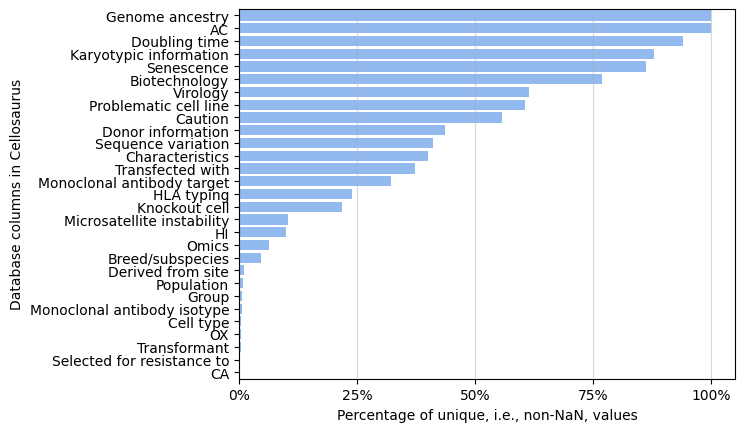

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# For each column, plot the number of unique values
percentages = []
for column in protac_cells_df.columns:
    if column in ['ID', 'DR', 'RX']:
        continue
    num_unique = len(protac_cells_df[column].unique())
    num_notna = len(protac_cells_df[column].dropna())
    # print(f'{column}: {num_unique} ({num_unique / len(protac_cells_df):.1%})')
    percentages.append({
        'Column': column,
        # len(protac_cells_df),
        'Perc (%)': num_unique / len(protac_cells_df[column].dropna()),
        'Unique/Not-NaN': 'Unique',
    })
    # percentages.append({
    #     'Column': column,
    #     'Perc (%)': num_notna / len(protac_cells_df),
    #     'Unique/Not-NaN': 'Not-NaN',
    # })
percentages = pd.DataFrame(percentages)

# Sort by non-NaN percentage
percentages = percentages.sort_values(by='Perc (%)', ascending=False)
# Get column order
unique_columns_ranking = percentages['Column'].unique().tolist()
print(unique_columns_ranking)

# Bar plot of the percentages, horizontal
ax = sns.barplot(x='Perc (%)', y='Column',
                 hue='Unique/Not-NaN', data=percentages, palette={'Unique': palette['blue']})
plt.xlabel('Percentage of unique, i.e., non-NaN, values')
plt.ylabel('Database columns in Cellosaurus')
# plt.title('Percentage of unique values per column')
# Set x-axis to percentage
plt.xticks(ticks=[0, 0.25, 0.5, 0.75, 1],
           labels=['0%', '25%', '50%', '75%', '100%'])
# Disable legend
plt.legend([], [], frameon=False)
plt.grid(axis='x', alpha=0.5)
plt.savefig('plots/cell_line_unique_values.pdf', bbox_inches='tight')
plt.show()

In [11]:
features_to_ignore = [
    'Problematic cell line',
    'Omics',
    'AC',
    'OX',
    'Doubling time',
]
unique_columns_ranking = [
    c for c in unique_columns_ranking if c not in features_to_ignore]
unique_columns_ranking

['Genome ancestry',
 'Karyotypic information',
 'Senescence',
 'Biotechnology',
 'Virology',
 'Caution',
 'Donor information',
 'Sequence variation',
 'Characteristics',
 'Transfected with',
 'Monoclonal antibody target',
 'HLA typing',
 'Knockout cell',
 'Microsatellite instability',
 'HI',
 'Breed/subspecies',
 'Derived from site',
 'Population',
 'Group',
 'Monoclonal antibody isotype',
 'Cell type',
 'Transformant',
 'Selected for resistance to',
 'CA']

genome ancestry, karyotypic information, senescence, biotechnology, virology, caution, donor information, sequence variation, characteristics, transfected with, monoclonal antibody target, HLA typing, knockout cell, microsatellite instability, hierarchy (HI), breed/subspecies, derived from site, population, group, monoclonal antibody isotype, cell type, transformant, selected for resistance to, category (CA).

In [12]:
import re

cell2description = {}
for i, row in protac_cells_df.iterrows():
    cell_description = ""
    for col in unique_columns_ranking:
        if pd.notnull(row[col]):
            # if len(col) > 2:
            #     cell_description += f"{col}: {row[col].strip()}"
            # else:
            #     cell_description += f"{row[col].strip()}"
            cell_description += f"{row[col].strip()}"
            cell_description += '\n'
    # Remove via regex all strings of the form "(PubMed=12345678)"
    cell_description = re.sub(r'\(PubMed=.*\)', '', cell_description)
    # Remove via regex all strings of the form "UBERON=UBERON_0002048."
    cell_description = re.sub(r'UBERON=.*\.', '', cell_description)
    cell_description = cell_description.strip()
    cell_description = cell_description.replace(' .', '.')
    cell_description = cell_description.replace('  ', ' ')

    cell2description[row['ID']] = cell_description

    if i < 10:
        print(len(cell_description), f'{cell_description[:500]}...')
        print('-' * 80)

print(
    f'Average length of cell line description: {sum([len(v) for v in cell2description.values()]) / len(cell2description):.1f}')

108 UniProtKB; P47712; Human PLA2G4A.
CVCL_D145 ! HL-1 Friendly Myeloma-653
Patented cell line.
IgG2a.
Hybridoma...
--------------------------------------------------------------------------------
107 UniProtKB; P47712; Human PLA2G4A.
CVCL_D145 ! HL-1 Friendly Myeloma-653
Patented cell line.
IgG1.
Hybridoma...
--------------------------------------------------------------------------------
159 A*03,25; B*37
In situ; Peripheral blood; 
Caucasian; French Canadian.
B-cell; CL=CL_0000236.
NCBI_TaxID; 10376; Epstein-Barr virus (EBV).
Transformed cell line...
--------------------------------------------------------------------------------
71 UniProtKB; Q5T5X7; Human BEND3.
CVCL_4032 ! P3X63Ag8.653
IgM.
Hybridoma...
--------------------------------------------------------------------------------
173 Established from parent cell line after two passages in the peritoneal cavity of C57BL/6 mice.
CVCL_IW90 ! 40
C57BL/6.
Metastatic; Peritoneum; 
ChEBI; CHEBI
Cancer cell line...
-------------------

In [165]:
import pickle

cell2description_filepath = os.path.join(
    data_dir, 'processed', 'cell2description.pkl'
)
with open(cell2description_filepath, 'wb') as f:
    pickle.dump(cell2description, f)

\begin{figure*}[t!]
    \centering
    \begin{subfigure}{0.5\textwidth}
        \centering
        \includegraphics[width=0.99\columnwidth]{plots/pytorch_performance_Accuracy.pdf}
        \caption{}
        \label{fig:pytorch_accuracy}
    \end{subfigure}%
    \begin{subfigure}{0.5\textwidth}
        \centering
        \includegraphics[width=0.99\columnwidth]{plots/pytorch_performance_ROC AUC.pdf}
        \caption{}
        \label{fig:pytorch_roc_auc}
    \end{subfigure}\\%
    \begin{subfigure}{0.5\textwidth}
        \centering
        \includegraphics[width=0.99\columnwidth]{plots/pytorch_performance_F1 Score.pdf}
        \caption{}
        \label{fig:pytorch_f1_score}
    \end{subfigure}%
    \begin{subfigure}{0.5\textwidth}
        \centering
        \includegraphics[width=0.99\columnwidth]{plots/pytorch_performance_Precision.pdf}
        \caption{}
        \label{fig:pytorch_precision}
    \end{subfigure}\\%
    \begin{subfigure}{0.5\textwidth}
        \centering
        \includegraphics[width=0.99\columnwidth]{plots/pytorch_performance_Recall.pdf}
        \caption{}
        \label{fig:pytorch_recall}
    \end{subfigure}%
    \caption{Performance metrics of the proposed deep learning models. (a) ROC-AUC. (b) F1 score. (c) Precision. (d) Recall.}
    \label{fig:pytorch_performance}
\end{figure*}

## Embeddings from Cell Descriptions

Once the descriptions are generated, we will use the `sentence-transformers` package to generate embeddings for the cell descriptions.

In [1]:
import torch

In [ ]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

model = SentenceTransformer(
    "sentence-transformers/all-mpnet-base-v2"
)

if torch.cuda.is_available():
    device = 0  # GPU
else:
    device = "cpu"

model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
  (2): Normalize()
)

In [45]:
embeddings = model.encode([
    """
UKF-NB-2rDACARB4
CVCL_RT02
Cancer cell line
NCBI_TaxID=9606; ! Homo sapiens (Human)
Part of: Resistant Cancer Cell Line (RCCL) collection.
Selected for resistance to: ChEBI; CHEBI:4305; Dacarbazine (DTIC; (5-(3,3-dimethyl-1-triazeno)imidazole-4-carboxamide)).
Derived from site: Metastatic; Bone marrow; UBERON=UBERON_0002371.
NCIt; C3270; Neuroblastoma
ORDO; Orphanet_635; Neuroblastoma
CVCL_9902 ! UKF-NB-2
""",
    """
UKF-NB-2rDOCE10
CVCL_RR83
NCBI_TaxID=9606; ! Homo sapiens (Human)
Part of: Resistant Cancer Cell Line (RCCL) collection.
Selected for resistance to: ChEBI; CHEBI:4672; Docetaxel anhydrous (Taxotere).
Derived from site: Metastatic; Bone marrow; UBERON=UBERON_0002371.
NCIt; C3270; Neuroblastoma
ORDO; Orphanet_635; Neuroblastoma
CVCL_9902 ! UKF-NB-2
Cancer cell line
""",
    """
FHS036i-sh18961C
CVCL_YY67
Induced pluripotent stem cell
NCBI_TaxID=9606; ! Homo sapiens (Human)
Part of: Framingham Heart Study (FHS) collection.
Part of: Next Generation Genetic Association studies (Next Gen) program cell lines.
Population: Caucasian.
Sequence variation: Mutation; HGNC; 3231; CELSR2; Simple; c.*919G; dbSNP=rs12740374; Zygosity=Homozygous; Note=Major haplotype (PubMed=28388431).
Omics: Transcriptome analysis by RNAseq.
Derived from site: In situ; Peripheral blood; UBERON=UBERON_0000178.
CVCL_YY66 ! FHS035i-sh18961A
""",
])
print(cos_sim(embeddings[0], embeddings[1]).item())
print(cos_sim(embeddings[0], embeddings[2]).item())
print(cos_sim(embeddings[1], embeddings[2]).item())

0.8759459257125854
0.28315800428390503
0.3522447347640991


By default, input text longer than 384 word pieces is truncated ([source](https://huggingface.co/sentence-transformers/all-mpnet-base-v2)).

In [161]:
import numpy as np
from tqdm.auto import tqdm
import random

tmp = {k: cell2description[k] for k in random.sample(
    list(cell2description.keys()), 1000) + protac_cells}

cell2embedding = {}
for cell, description in tqdm(tmp.items(), desc='Get sentence embeddings'):
    # Chunk the description in chunks of maximum 384 length
    chunk_len = 384
    chunks = [description[i:i+chunk_len]
              for i in range(0, len(description), chunk_len)]
    embeddings = np.mean(model.encode(chunks), axis=0)
    # embeddings = model.encode(chunks[0])
    cell2embedding[cell] = embeddings

Get sentence embeddings:   0%|          | 0/1138 [00:00<?, ?it/s]

In [170]:
emb = cell2embedding[list(cell2embedding.keys())[0]]
print(f'Embedding type: {type(emb)}')
print(f'Embedding size: {emb.shape}')

Embedding type: <class 'numpy.ndarray'>
Embedding size: (768,)


In [ ]:
import pickle

cell2embedding_filepath = os.path.join(
    data_dir, 'cell2embedding.pkl'
)
with open(cell2embedding_filepath, 'wb') as f:
    pickle.dump(cell2embedding, f)

In [3]:
import pickle

cell2embedding_filepath = os.path.join(
    data_dir, 'cell2embedding.pkl'
)
with open(cell2embedding_filepath, 'rb') as f:
    cell2embedding = pickle.load(f)
print(f'Number of cell lines: {len(cell2embedding)}')

Number of cell lines: 1138


In [30]:
list(cell2embedding.keys())[:3]

['GM15119', 'GM17453', '84 BLCL']

In [37]:
for k in cell2embedding.keys():
    if 'HT-29' in k:
        print(k)

HT-29/cDDP
HT-29


## Save to H5 File

In [48]:
import h5py
import numpy as np
import pandas as pd


def save_embeddings_to_hdf5(embeddings, file_path):
    """
    Save the embeddings dictionary to an HDF5 file, skipping datasets that already exist.

    Parameters:
    - embeddings: dict, where the key is the name identifier and the value is the numpy array of embeddings.
    - file_path: str, the path to the output HDF5 file.
    """
    with h5py.File(file_path, 'w') as h5f:
        for name_id, embedding in embeddings.items():
            if pd.isnull(embedding).any():
                print(f"NaN value found in embedding for '{name_id}'. Skipping...")
                continue
            if pd.isnull(name_id):
                print(f"NaN value found in name_id. Skipping...")
                continue
            if name_id in h5f:
                print(f"Dataset '{name_id}' already exists. Skipping...")
                continue  # Skip this name_id if it already exists
            # Create dataset with compression
            h5f.create_dataset(name_id.replace('/', '##'), data=embedding) #, compression="gzip", compression_opts=9)


def verify_embeddings(file_path, original_embeddings):
    """
    Verify that embeddings stored in an HDF5 file match the original embeddings.

    Parameters:
    - file_path: str, the path to the HDF5 file.
    - original_embeddings: dict, the original embeddings dictionary.
    """
    with h5py.File(file_path, 'r') as h5f:
        for name_id, original_embedding in original_embeddings.items():
            name_id = name_id.replace('/', '##')
            if name_id not in h5f:
                print(f"Dataset '{name_id}' not found in the HDF5 file.")
                continue
            
            # Retrieve the dataset from the file
            stored_embedding = h5f[name_id]
            
            # Compare the stored embedding with the original one
            if np.array_equal(stored_embedding, original_embedding):
                # print(f"Dataset '{name_id}' matches the original embedding.")
                pass
            else:
                print(f"Dataset '{name_id}' does not match the original embedding.")


cell2embedding_h5_filepath = os.path.join(
    data_dir, 'cell2embedding.h5'
    # '..', 'cellovec', 'data', 'cell2embedding.h5'
)
save_embeddings_to_hdf5(cell2embedding, cell2embedding_h5_filepath)
verify_embeddings(cell2embedding_h5_filepath, cell2embedding)

In [47]:
list(cell2embedding.keys())[:3]

['GM15119', 'GM17453', '84 BLCL']

In [51]:
# Save list of cell lines to a text file under ../data
cell_lines_filepath = os.path.join(data_dir, 'current_cell_lines.txt')
with open(cell_lines_filepath, 'w') as f:
    for cell in cell2embedding.keys():
        f.write(f'{cell}\n')
print(f'Number of cell lines: {len(cell2embedding)}')

Number of cell lines: 1138


## UMAP Cell Embeddings

In [14]:
import pickle

embeddings_path = os.path.join(data_dir, 'cell2embedding.pkl')
with open(embeddings_path, 'rb') as f:
    cell2embedding = pickle.load(f)
print(f'Number of cell lines: {len(cell2embedding)}')

Number of cell lines: 1138


In [15]:
import umap
from sklearn.preprocessing import StandardScaler

In [23]:
# Define UMAP and Scaler
umap_reducer = umap.UMAP(
    n_neighbors=30,  # Good value: 50
    min_dist=0.8,  # Good value: 0.5
    # spread=1.0, # Good value: (not set, default)
    metric='euclidean',
    random_state=42,
    unique=True,
    # n_epochs=100,
    init='spectral',  # Default: 'spectral'
    verbose=False,
)
scaler = StandardScaler()

# Get the embeddings as a numpy array
data = scaler.fit_transform(list(cell2embedding.values()))
data = umap_reducer.fit_transform(data)

# Get the UMAP embedding coordinates
umap_embeddings = {
    'UMAP 1': [],
    'UMAP 2': [],
    'Cell ID': [],
}
umap_embeddings['UMAP 1'] = data[:, 0].tolist()
umap_embeddings['UMAP 2'] = data[:, 1].tolist()
# umap_embeddings['Cell ID'] = list(cell2embedding.keys())
umap_embeddings['Cell ID'] = [cell2data[c]['CA']
                              for c in cell2embedding.keys()]

# Transform to dataframe and drop duplicates
umap_embeddings = pd.DataFrame(umap_embeddings).drop_duplicates()
umap_embeddings.head()

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


,UMAP 1,UMAP 2,Cell ID
0,-0.368673,9.499292,Transformed cell line
1,-0.668173,8.160005,Transformed cell line
2,-0.164419,9.115404,Transformed cell line
4,6.897954,12.088582,Finite cell line
5,1.488047,14.562062,Cancer cell line


In [29]:
umap_embeddings['Cell ID'].unique().tolist()

['Transformed cell line',
 'Finite cell line',
 'Cancer cell line',
 'Embryonic stem cell',
 'Hybridoma',
 'Induced pluripotent stem cell',
 'Spontaneously immortalized cell line',
 'Somatic stem cell',
 'Hybrid cell line',
 'Conditionally immortalized cell line',
 'Telomerase immortalized cell line',
 'Factor-dependent cell line',
 'Undefined cell line type']

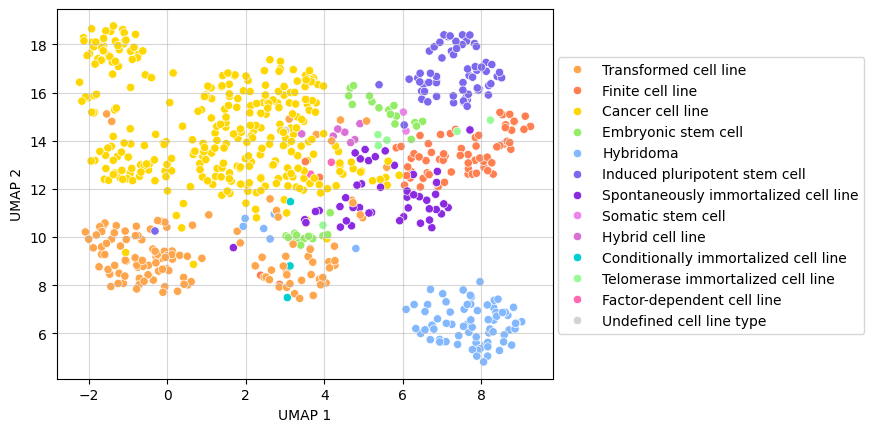

In [47]:
# Define a rainbow color pattern for the Cell IDs (as a dictionary)
# Thanks Chat-GPT4o for the color suggestions! (it started from a rainbow pattern and "merged it with my palette above")
colors = {
    'Transformed cell line': '#FFA54C',  # Orange
    'Finite cell line': '#FF7F50',       # Coral (closer to orange)
    'Cancer cell line': '#FFD700',       # Gold (yellowish)
    'Embryonic stem cell': '#94ED67',    # Green (from palette)
    'Hybridoma': '#83B8FE',              # Blue (from palette)
    'Induced pluripotent stem cell': '#7B68EE',  # Medium Slate Blue (indigo)
    'Spontaneously immortalized cell line': '#8A2BE2', # Blue Violet
    'Somatic stem cell': '#EE82EE',      # Violet
    'Hybrid cell line': '#DA70D6',       # Orchid (violet)
    'Conditionally immortalized cell line': '#00CED1', # Dark Turquoise (blueish)
    'Telomerase immortalized cell line': '#98FB98', # Pale Green
    'Factor-dependent cell line': '#FF69B4', # Hot Pink (closer to violet)
    'Undefined cell line type': '#D3D3D3',  # Gray
}
sns.scatterplot(data=umap_embeddings, x='UMAP 1', y='UMAP 2',
                hue='Cell ID', palette=colors) #sns.color_palette('hls', 13))
# Make the legend external
plt.legend(bbox_to_anchor=(1.01, 0.87), borderaxespad=0)
# plt.title('UMAP embedding of cell lines')
plt.grid(axis='both', alpha=0.5)
plt.savefig('plots/umap_cell_lines.pdf', bbox_inches='tight')
plt.show()

## Embeddings from Abstracts (NOT IMPLEMENTED)

In [ ]:
# !pip install biopython beautifulsoup4

In [1]:
from bs4 import BeautifulSoup


def extract_abstract_from_html(html_content):
    """
    Extract the abstract text from a PubMed article's HTML content.

    :param html_content: The HTML content as a byte string.
    :return: The abstract text if available, otherwise an error message.
    """
    try:
        # Parse the HTML content
        soup = BeautifulSoup(html_content, "html.parser")

        # Find the abstract text
        abstract_text = soup.find("abstracttext")
        if abstract_text:
            return abstract_text.get_text()
        else:
            return "Abstract not found."
    except Exception as e:
        return f"An error occurred: {str(e)}"

# Example usage
# html_content = b'...'  # Replace with the actual HTML content
# abstract = extract_abstract_from_html(html_content)
# print(abstract)

In [32]:
from Bio import Entrez


def get_pubmed_abstract(pubmed_id):
    """
    Retrieve the abstract of a PubMed article using its PubMed ID.

    :param pubmed_id: The PubMed ID of the article.
    :return: The abstract of the article.
    """
    # Use your email here. NCBI recommends providing it.
    Entrez.email = "your.email@example.com"

    try:
        handle = Entrez.efetch(db="pubmed", id=pubmed_id,
                               rettype="abstract", retmode="html")
        abstract = handle.read()
        handle.close()
        return extract_abstract_from_html(abstract)
    except Exception as e:
        return f"An error occurred: {str(e)}"


cells = {
    'MV4-11': {
        'pubmed': [
            '1423625',
            '2656885',
            '3496132',
            '8353274',
            '8358709',
            '9195772',
            '12529668',
            '14504097',
            '14671638',
            '15843827',
            '16408098',
            '19608861',
            '20215515',
            '20922763',
            '21552520',
            '22460905',
            '25485619',
            '25877200',
            '25984343',
            '26589293',
            '27397505',
            '30285677',
            '30629668',
            '30894373',
            '31068700',
            '35839778',
        ],
    },
    'LNCaP': {
        'pubmed': [
            '2734981',
            '3335022',
            '3518877',
            '6831420',
            '8687134',
            '9018337',
            '9090379',
            '10702678',
            '10972993',
            '11135431',
            '11172901',
            '11304728',
            '11414198',
            '11416159',
            '12606952',
            '12725112',
            '14518029',
            '15162376',
            '15486987',
            '22213130',
            '22278370',
            '23671654',
            '24587179',
            '24618588',
            '25485619',
            '25877200',
            '26256267',
            '26589293',
            '26972028',
            '27036029',
            '27141528',
            '29233929',
            '29660373',
            '29739788',
            '30787054',
            '35502546',
        ],
    },
    'MM.1S': {
        'pubmed': [
            '12691914',
            '14760100',
            '16956823',
            '17692805',
            '18647998',
            '21173094',
            '22460905',
            '25485619',
            '25688540',
            '25877200',
            '25984343',
            '26589293',
            '27397505',
            '28196595',
            '30285677',
            '30545397',
            '30894373',
            '30971826',
            '31068700',
            '32123307',
            '35839778',
        ],
    },
}

# # Example usage
# pubmed_id = "1659122"  # Replace with a real PubMed ID
# print(get_pubmed_abstract(pubmed_id))

pubmed_ids = [
    "16780947",
    "20054396",
    "21179087",
    "23257783",
    "23292937",
    # "25485619",
    # "26589293",
    # "26787899",
    # "27566572",
    # "29416618",
    # "29666304",
    # --------------------
    "2476442",  # Other cell type
]
pubmed2abstract = {}
for pubmed_id in pubmed_ids:
    pubmed2abstract[pubmed_id] = get_pubmed_abstract(pubmed_id)
    print(f"Retrieved abstract for PubMed ID: {pubmed2abstract[pubmed_id]}")
    print('-' * 80)

c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


Retrieved abstract for PubMed ID: A novel lymphoma cell line, designated TMD8 was established from cells of a patient with diffuse large B-cell lymphoma. TMD8 cells expressed HES1 mRNA, suggesting constitutive activation of Notch signaling. TMD8 cells expressed normal-sized Notch1 protein, and showed no mutations in the NOTCH1 gene. Cell growth was suppressed by gamma-secretase inhibitors (GSI). It was reported that GSI suppressed growth of T-cell acute lymphoblastic leukemia (T-ALL) cell lines, which frequently had NOTCH1 mutations. In addition to T-ALL, TMD8 is another unique cell line sensitive to GSI, and is useful to study effects of GSI in molecular targeting therapy.
--------------------------------------------------------------------------------
Retrieved abstract for PubMed ID: A role for B-cell-receptor (BCR) signalling in lymphomagenesis has been inferred by studying immunoglobulin genes in human lymphomas and by engineering mouse models, but genetic and functional evidence 

In [16]:
from transformers import pipeline
import torch

if torch.cuda.is_available():
    device = 0  # GPU
else:
    device = "cpu"
pipe = pipeline(
    "feature-extraction",
    model="dmis-lab/biobert-v1.1",
    device=device,
)

In [33]:
import numpy as np

pubmed2features = {}

for pubmed_id, abstract in pubmed2abstract.items():
    print('-' * 80)
    print(f"PubMed ID: {pubmed_id}")
    print(f"Abstract: {abstract}")

    # Extract features
    features = pipe(abstract[:512])

    print(f"Number of features: {len(features)}")
    print(f"Shape of the features: {np.array(features).shape}")

    pubmed2features[pubmed_id] = np.array(features)

--------------------------------------------------------------------------------
PubMed ID: 16780947
Abstract: A novel lymphoma cell line, designated TMD8 was established from cells of a patient with diffuse large B-cell lymphoma. TMD8 cells expressed HES1 mRNA, suggesting constitutive activation of Notch signaling. TMD8 cells expressed normal-sized Notch1 protein, and showed no mutations in the NOTCH1 gene. Cell growth was suppressed by gamma-secretase inhibitors (GSI). It was reported that GSI suppressed growth of T-cell acute lymphoblastic leukemia (T-ALL) cell lines, which frequently had NOTCH1 mutations. In addition to T-ALL, TMD8 is another unique cell line sensitive to GSI, and is useful to study effects of GSI in molecular targeting therapy.


c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\transformers\pipelines\base.py:997: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Number of features: 1
Shape of the features: (1, 134, 768)
--------------------------------------------------------------------------------
PubMed ID: 20054396
Abstract: A role for B-cell-receptor (BCR) signalling in lymphomagenesis has been inferred by studying immunoglobulin genes in human lymphomas and by engineering mouse models, but genetic and functional evidence for its oncogenic role in human lymphomas is needed. Here we describe a form of 'chronic active' BCR signalling that is required for cell survival in the activated B-cell-like (ABC) subtype of diffuse large B-cell lymphoma (DLBCL). The signalling adaptor CARD11 is required for constitutive NF-kappaB pathway activity and survival in ABC DLBCL. Roughly 10% of ABC DLBCLs have mutant CARD11 isoforms that activate NF-kappaB, but the mechanism that engages wild-type CARD11 in other ABC DLBCLs was unknown. An RNA interference genetic screen revealed that a BCR signalling component, Bruton's tyrosine kinase, is essential for the

In [34]:
# Calculate the cosine similarity between the features of all pairs of articles
from sklearn.metrics.pairwise import cosine_similarity

pubmed_ids = list(pubmed2features.keys())
pubmed_ids.sort()
for i, pubmed_id1 in enumerate(pubmed_ids):
    for j, pubmed_id2 in enumerate(pubmed_ids):
        if i < j:
            print('-' * 80)
            print(f"PubMed ID 1: {pubmed_id1}")
            print(f"PubMed ID 2: {pubmed_id2}")
            print(
                f"Cosine similarity: {np.mean(cosine_similarity(pubmed2features[pubmed_id1][0], pubmed2features[pubmed_id2][0]))}")

--------------------------------------------------------------------------------
PubMed ID 1: 16780947
PubMed ID 2: 20054396
Cosine similarity: 0.5031364979399338
--------------------------------------------------------------------------------
PubMed ID 1: 16780947
PubMed ID 2: 21179087
Cosine similarity: 0.4757581799666462
--------------------------------------------------------------------------------
PubMed ID 1: 16780947
PubMed ID 2: 23257783
Cosine similarity: 0.47590786790387574
--------------------------------------------------------------------------------
PubMed ID 1: 16780947
PubMed ID 2: 23292937
Cosine similarity: 0.4879428252319288
--------------------------------------------------------------------------------
PubMed ID 1: 16780947
PubMed ID 2: 2476442
Cosine similarity: 0.4214291931633308
--------------------------------------------------------------------------------
PubMed ID 1: 20054396
PubMed ID 2: 21179087
Cosine similarity: 0.5045157039333007
----------------------

In [47]:
cell_emb1 = np.mean(
    np.vstack([pubmed2features[p][0]
              for p in ["16780947", "20054396", "21179087", "23257783", "23292937"]]),
    axis=0,
)
cell_emb2 = np.mean(pubmed2features["2476442"][0], axis=0)

print(cell_emb1.shape)
print(cell_emb2.shape)

print(
    f"Cosine similarity: {np.mean(cosine_similarity(cell_emb1[None], cell_emb2[None]))}")

(768,)
(768,)
Cosine similarity: 0.931316114549088


In [17]:
# Load tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "jinaai/jina-embeddings-v2-base-en"
    # "sentence-transformers/all-mpnet-base-v2"
)
encoded = tokenizer('CELSR2')
tokenizer.decode(encoded['input_ids'])

'[CLS] celsr2 [SEP]'

In [18]:
tokenizer = AutoTokenizer.from_pretrained(
    # "jinaai/jina-embeddings-v2-base-en"
    "sentence-transformers/all-mpnet-base-v2"
)
encoded = tokenizer('CELSR2')
tokenizer.decode(encoded['input_ids'])

'<s> celsr2 </s>'

In [2]:
import pandas as pd

pd.DataFrame(cell_lines).head()

,ID,AC,SY,DR,RX,CC,OX,HI,CA,DT
0,#132 PC3-1-SC-E8,CVCL_B0T9,Z48-5MG-70,[Wikidata; Q108819335],[Patent=EP0501779A1;],"[Group: Patented cell line., Registration: Int...",NCBI_TaxID=10090; ! Mus musculus (Mouse),CVCL_D145 ! HL-1 Friendly Myeloma-653,Hybridoma,Created: 23-09-21; Last updated: 30-01-24; Ver...
1,#132 PL12 SC-D1,CVCL_B0T8,Z48-5MG-63,[Wikidata; Q108819336],[Patent=EP0501779A1;],"[Group: Patented cell line., Registration: Int...",NCBI_TaxID=10090; ! Mus musculus (Mouse),CVCL_D145 ! HL-1 Friendly Myeloma-653,Hybridoma,Created: 23-09-21; Last updated: 30-01-24; Ver...
2,#15310-LN,CVCL_E548,15310-LN; TER461; TER-461; Ter 461; TER479; TE...,"[dbMHC; 48439, ECACC; 94050311, IHW; IHW09326,...",NaN,[Part of: 12th International Histocompatibilit...,NCBI_TaxID=9606; ! Homo sapiens (Human),NaN,Transformed cell line,Created: 22-10-12; Last updated: 30-01-24; Ver...
3,#16-15,CVCL_KA96,NaN,"[RCB; RCB4635, Wikidata; Q54422067]",[PubMed=25400923;],"[Monoclonal antibody isotype: IgM., Monoclonal...",NCBI_TaxID=10116; ! Rattus norvegicus (Rat),CVCL_4032 ! P3X63Ag8.653,Hybridoma,Created: 22-08-17; Last updated: 21-03-23; Ver...
4,#40a,CVCL_IW91,NaN,[Wikidata; Q54422071],[PubMed=28159921;],[Characteristics: Established from parent cell...,NCBI_TaxID=10090; ! Mus musculus (Mouse),CVCL_IW90 ! 40,Cancer cell line,Created: 15-05-17; Last updated: 29-06-23; Ver...
